In [ ]:
!pip install scikit-learn-extra

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import arff
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import k_means, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples ,pairwise_distances
from sklearn_extra.cluster import KMedoids

In [58]:
data = arff.loadarff('Dataset/PhishingData.arff')
df = pd.DataFrame(data[0])
df.drop(columns=['Result'], inplace=True)
df.describe()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
count,1353,1353,1353,1353,1353,1353,1353,1353,1353
unique,3,3,3,3,3,3,3,2,2
top,b'1',b'0',b'1',b'-1',b'-1',b'0',b'0',b'1',b'0'
freq,767,639,751,617,610,473,563,825,1198


In [7]:
#one_hot_encoder = OneHotEncoder()
#df_encoded = one_hot_encoder.fit_transform(df).toarray()
#pd.DataFrame(df_encoded).head()

In [9]:
def plot_elbow_and_silhouette_curves(elbow_values, silhouette_scores, start_n_clusters=1):
    fig, ax = plt.subplots(2, 1 , figsize=(20, 9))
    ax[0].set_ylabel('Variance Intraclasses')
    ax[0].set_xlabel('Nombre de cluster')
    ax[0].set_xticks(np.arange(start_n_clusters, len(elbow_values)+start_n_clusters))
    ax[0].plot(np.arange(start_n_clusters, len(elbow_values)+start_n_clusters), elbow_values, 'go-', linewidth=2, markersize=5)
    ax[1].set_ylabel('Silhouette')
    ax[1].set_xlabel('Nombre de cluster')
    ax[1].set_xticks(np.arange(start_n_clusters, len(silhouette_scores)+start_n_clusters))
    ax[1].plot(np.arange(start_n_clusters, len(silhouette_scores)+start_n_clusters), silhouette_scores, 'go-', linewidth=2, markersize=5)
    fig.tight_layout()
    plt.show()

In [10]:
def hamming_distance(x1, x2):
    return np.sum(x1 != x2)

# PAM Clustering

In [61]:
%%time
#D_matrix_encoded = pairwise_distances(df_encoded, metric = hamming_distance)
D_matrix = pairwise_distances(df, metric = hamming_distance)

CPU times: user 18.9 s, sys: 113 ms, total: 19 s
Wall time: 19.6 s


In [62]:
# Describe D_matrix
pd.DataFrame(D_matrix.reshape(len(df)**2, 1), columns=['dists']).describe()

,dists
count,1.830609e+06
mean,4.998019e+00
std,1.613870e+00
min,0.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,6.000000e+00
max,9.000000e+00


In [63]:
# Describe D_matrix_encoded
pd.DataFrame(D_matrix_encoded.reshape(len(df)**2, 1), columns=['dists']).describe()

,dists
count,1.830609e+06
mean,9.996037e+00
std,3.227740e+00
min,0.000000e+00
25%,8.000000e+00
50%,1.000000e+01
75%,1.200000e+01
max,1.800000e+01


In [64]:
%%time
k_medoids_elbow_values = []
k_medoids_silhouette_scores = []
for i in np.arange(2, 15):
    kmedoids = KMedoids(n_clusters=i, init='build', method='pam', metric='precomputed').fit(D_matrix)
    k_medoids_silhouette_scores.append(silhouette_score(D_matrix, kmedoids.labels_, metric='precomputed') if i>1 else 0)
    k_medoids_elbow_values.append(kmedoids.inertia_)

CPU times: user 11.4 s, sys: 42.2 ms, total: 11.4 s
Wall time: 11.5 s


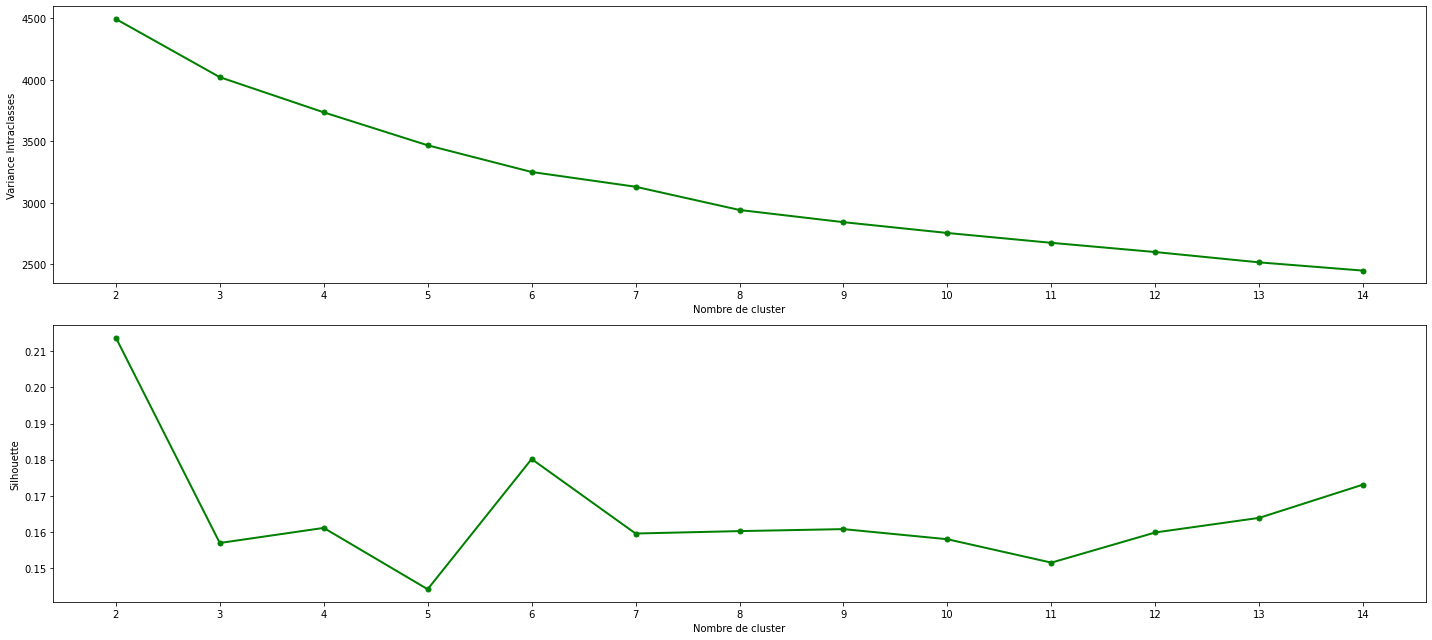

In [65]:
plot_elbow_and_silhouette_curves(k_medoids_elbow_values, k_medoids_silhouette_scores, 2)

[]

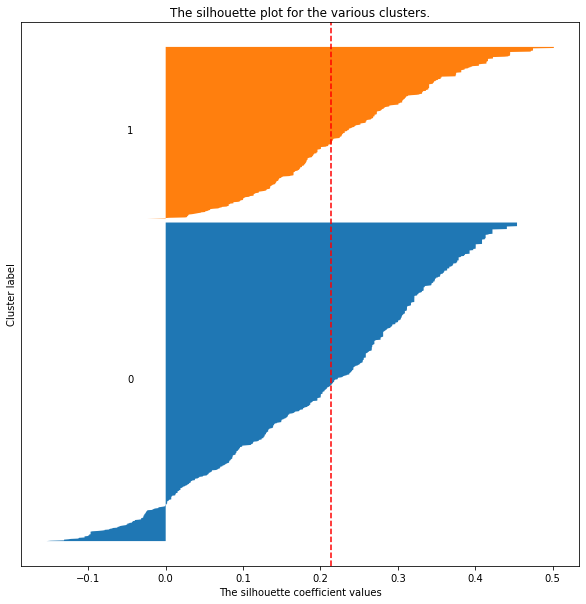

In [66]:
n_clusters = 2
kmedoids = KMedoids(n_clusters=n_clusters, init='build', method='pam', metric='precomputed').fit(D_matrix)

sample_silhouette_values = silhouette_samples(D_matrix, kmedoids.labels_, metric='precomputed')


fig, ax = plt.subplots(figsize=(10, 10))
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kmedoids.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_score(D_matrix, kmedoids.labels_, metric='precomputed'), color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks

# Interprétation

Il est important de noter que la métrique de distance que nous avons utilisé est celle de **Hamming**

# CAH Clustering

In [75]:
%%time
cah_elbow_values = []
cah_silhouette_scores = []
for i in np.arange(1, 30):
    cah = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single').fit(D_matrix)
    cah_silhouette_scores.append(silhouette_score(D_matrix, cah.labels_, metric='precomputed') if i>1 else 0)
    cah_elbow_values.append(0)

CPU times: user 1.35 s, sys: 15.9 ms, total: 1.37 s
Wall time: 1.36 s


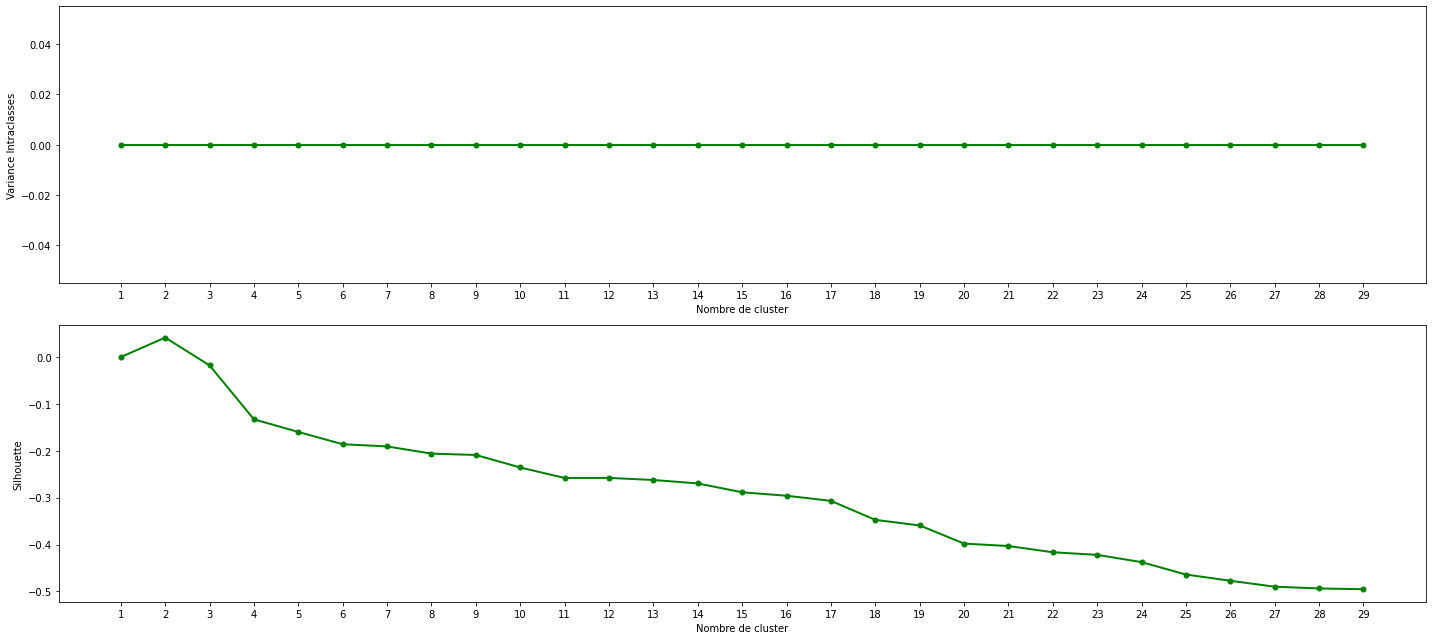

In [78]:
plot_elbow_and_silhouette_curves(cah_elbow_values, cah_silhouette_scores)

In [80]:
pd.DataFrame(cah_elbow_values).describe()

,0
count,29.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [79]:
cah_elbow_values

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]